# Clean dataset

* The dataset is composed of the labels 0=Background, 1=foreground, 2=unlabeled.
* Which means, 2 doesn't matter/are wrong biases, because we don't know if it's really 0 or 1 -> if used, it will confuse the model.

In [1]:
import os
from os import listdir
from os.path import join

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage

DATASET_PATH = "/projects/nian/synthrad2025/Vesuvius/DataSet"

In [2]:
def load_nii(file_path):
    """
    Loads a NIfTI file and returns the data array and the affine matrix.
    
    Args:
        file_path (str): Path to the .nii or .nii.gz file.
        
    Returns:
        tuple: (data_array (np.ndarray), affine_matrix (np.ndarray))
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f" The file at {file_path} was not found.")
    
    # Load the NIfTI object
    nii_img = nib.load(file_path)
    
    # Get the data as a numpy array
    # usage of get_fdata() is preferred as it automatically handles data typing
    data = nii_img.get_fdata()
    
    # Get the affine (position/orientation in space)
    affine = nii_img.affine
    
    print(f"Loaded: {os.path.basename(file_path)}")
    print(f"Shape: {data.shape}")
    
    return data, affine


In [21]:
def save_nii_with_metadata(data_to_save, original_nii_file_path, output_filepath):
    """
    Saves a NumPy array as a NIfTI file, inheriting the affine matrix and 
    header information from an original NIfTI file.
    
    Args:
        data_to_save (np.ndarray): The 3D NumPy array containing the segmented mask.
        original_nii_file_path (str): The file path to the original NIfTI file.
        output_filepath (str): The desired path and filename for the new NIfTI file.
        
    Returns:
        str: The path to the newly saved file.
    """
    if not os.path.exists(original_nii_file_path):
        raise FileNotFoundError(f"Original file not found: {original_nii_file_path}")

    # 1. Load the original image object
    # We only need its header and affine, not the data itself
    original_img = nib.load(original_nii_file_path)
    
    # Check if the shapes match (important validation)
    # 2. Extract Affine and Header
    affine_matrix = original_img.affine
    header_data = original_img.header

    # 3. Create the new NIfTI image object
    # Use the segmented data array and the affine matrix from the original file
    try:
        new_img = nib.Nifti1Image(data_to_save, affine_matrix, header_data)
    except: 
         new_img = nib.Nifti1Image(data_to_save, affine_matrix)
    
    # 4. Update Header Datatype (Optional but recommended for masks)
    # Masks are usually integers (e.g., int8 or int16)
    # This prevents the mask from being saved unnecessarily as a float64.
    new_img.set_data_dtype(np.int16) 
    
    # 5. Save the file
    nib.save(new_img, output_filepath)
    
    print(f"Successfully saved mask to: {output_filepath}")
    return output_filepath

In [22]:
def plot_3d(data, label_data=None, slice_indices=None, title="Orthogonal View", alpha=0.5):
    """
    Plots an orthogonal view (Sagittal, Coronal, Axial) of the 3D data, 
    with an optional segmentation overlay.
    
    Args:
        data (np.ndarray): The primary 3D image data (e.g., MRI scan).
        label_data (np.ndarray, optional): The 3D segmentation mask. Defaults to None.
        slice_indices (tuple, optional): (x, y, z) indices to slice. Defaults to the center.
        title (str): Title of the plot.
        alpha (float): Transparency level for the label overlay (0.0=Invisible, 1.0=Opaque).
    """
    # 1. Input Validation and Shape Handling
    if len(data.shape) not in (3, 4):
        raise ValueError("Input 'data' must be 3D or 4D.")
    if len(data.shape) == 4:
        data = data[:, :, :, 0]
        print("Using first volume (t=0) of 4D anatomical data.")
        
    if label_data is not None:
        if label_data.shape != data.shape:
            raise ValueError("Data and label_data must have matching 3D shapes.")
        if len(label_data.shape) == 4:
            label_data = label_data[:, :, :, 0]
            print("Using first volume (t=0) of 4D label data.")

    # 2. Determine Slice Indices
    x_center, y_center, z_center = [s // 2 for s in data.shape]
    
    if slice_indices:
        x, y, z = slice_indices
    else:
        x, y, z = x_center, y_center, z_center

    # 3. Create the Plot Figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    # 4. Plotting Loop (Sagittal, Coronal, Axial)
    for i, (idx, dim_name) in enumerate(zip([x, y, z], ["Sagittal", "Coronal", "Axial"])):
        
        # Extract slices
        if i == 0: # Sagittal (X-plane)
            data_slice = np.rot90(data[idx, :, :])
            if label_data is not None:
                label_slice = np.rot90(label_data[idx, :, :])
        elif i == 1: # Coronal (Y-plane)
            data_slice = np.rot90(data[:, idx, :])
            if label_data is not None:
                label_slice = np.rot90(label_data[:, idx, :])
        else: # Axial (Z-plane)
            data_slice = np.rot90(data[:, :, idx])
            if label_data is not None:
                label_slice = np.rot90(label_data[:, :, idx])

        # Plot Anatomical Data (Background)
        axes[i].imshow(data_slice, cmap="gray")
        
        # Plot Label Data (Foreground Overlay)
        if label_data is not None:
            # Mask out zero values (background) in the label_slice
            masked_labels = np.ma.masked_where(label_slice == 0, label_slice)
            
            # Use a non-grayscale colormap (e.g., 'jet') for the mask
            # Apply the desired transparency (alpha)
            axes[i].imshow(
                masked_labels, 
                cmap="jet", # Use a vibrant colormap for labels
                alpha=alpha,
                # Interpolation='nearest' makes segmentation lines sharp
                interpolation='nearest' 
            )

        # Set titles and clean up axes
        axes[i].set_title(f"{dim_name} ({['x', 'y', 'z'][i]}={idx})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Loaded: 2290837.nii.gz
Shape: (320, 320, 320)
Loaded: 2290837.nii.gz
Shape: (320, 320, 320)


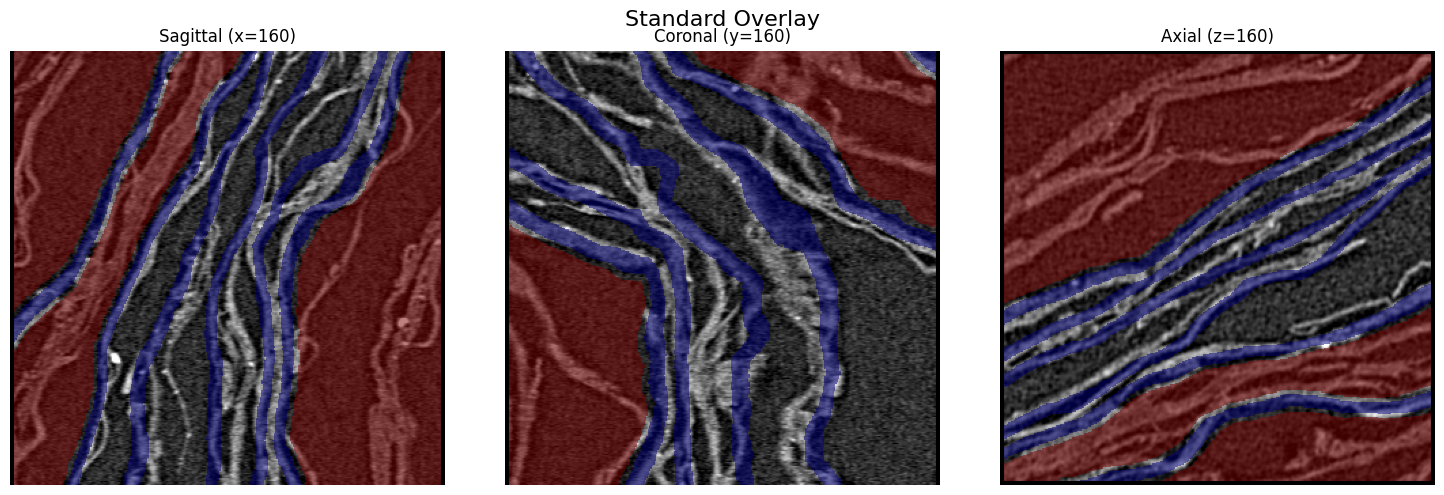

In [23]:
file_example = join(DATASET_PATH, "train_images_nii/2290837.nii.gz")
label_example = join(DATASET_PATH, "train_labels_nii/2290837.nii.gz")

volume_data, affine = load_nii(file_example)
label_data, affine = load_nii(label_example)

plot_3d(volume_data, label_data=label_data, title="Standard Overlay", alpha=0.5)

## The edges were padded with the value 0. 
* This will be removed to ensure smaller shapes!

In [24]:
def detect_deges_with_content(volume):
    # Find indices where any data exists along specific axes
    # This avoids creating a massive list of every single non-zero point
    
    # Check Z axis
    z_any = np.any(volume > 0, axis=(1, 2))
    z_min, z_max = np.where(z_any)[0][[0, -1]]
    
    # Check Y axis
    y_any = np.any(volume > 0, axis=(0, 2))
    y_min, y_max = np.where(y_any)[0][[0, -1]]
    
    # Check X axis
    x_any = np.any(volume > 0, axis=(0, 1))
    x_min, x_max = np.where(x_any)[0][[0, -1]]

    return x_min, x_max, y_min, y_max, z_min, z_max  #volume[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]

def crop_edges_without_content(volume_data, label_data, coord):
    x_min, x_max, y_min, y_max, z_min, z_max = detect_deges_with_content(volume=label_data)
    return volume_data[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1], label_data[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]

Loaded: 2290837.nii.gz
Shape: (320, 320, 320)
Loaded: 2290837.nii.gz
Shape: (320, 320, 320)


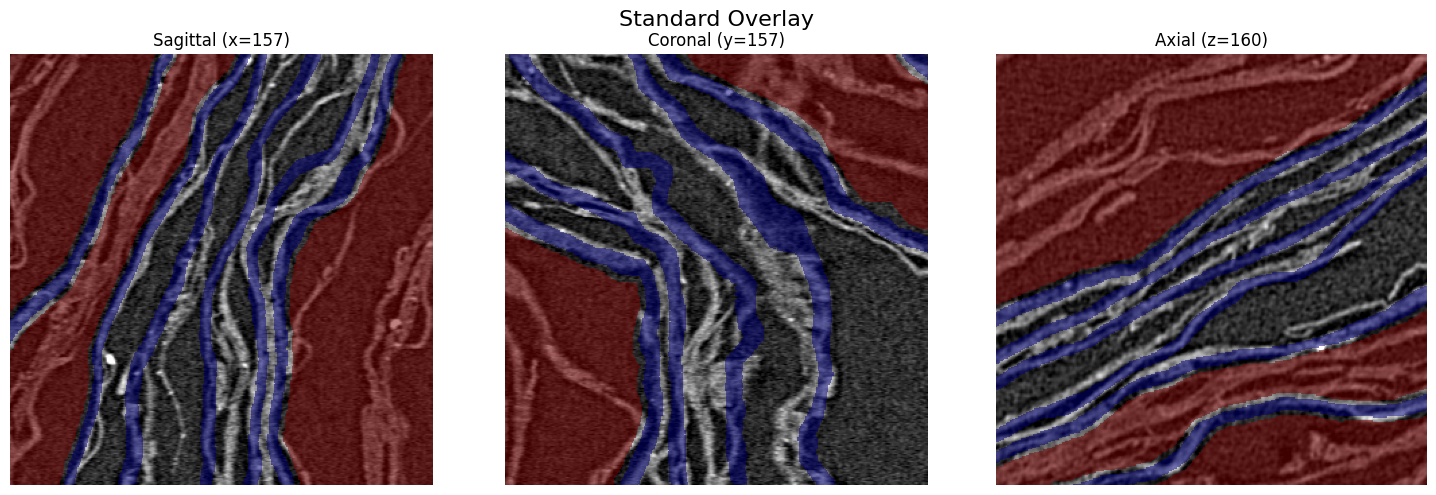

In [ ]:
file_example = join(DATASET_PATH, "train_images_nii/2290837.nii.gz")
label_example = join(DATASET_PATH, "train_labels_nii/2290837.nii.gz")

volume_data, affine = load_nii(file_example)
label_data, affine = load_nii(label_example)
volume_data_crop, label_data_crop = crop_edges_without_content(volume_data, label_data)


plot_3d(volume_data_crop, label_data=label_data_crop, title="Standard Overlay", alpha=0.5)

## Remove the label 2

In [26]:
import numpy as np
from scipy import ndimage 

def get_connected_components(label_data):
    """
    
    Args:
        label_data (np.ndarray): The 3D label mask data (containing 0, 1, 2).

        
    Returns:
        tuple: (labeled_regions (np.ndarray), num_components (int))
    """

    # 1. Filtering: Create a binary mask where only the target label is True.
    target_mask = (label_data == 0) | (label_data == 1)
    
    # 2. Connected Components Analysis
    #    ndimage.label only considers adjacent voxels that are True (1) to be connected.
    #    Any voxel set to False (0) acts as a break in connectivity.
    labeled_regions, num_components = ndimage.label(target_mask)
    
    print(f"\nFound {num_components} distinct, non-connected regions.")

    return labeled_regions, num_components

Loaded: 2290837.nii.gz
Shape: (320, 320, 320)
Loaded: 2290837.nii.gz
Shape: (320, 320, 320)

Found 2 distinct, non-connected regions.


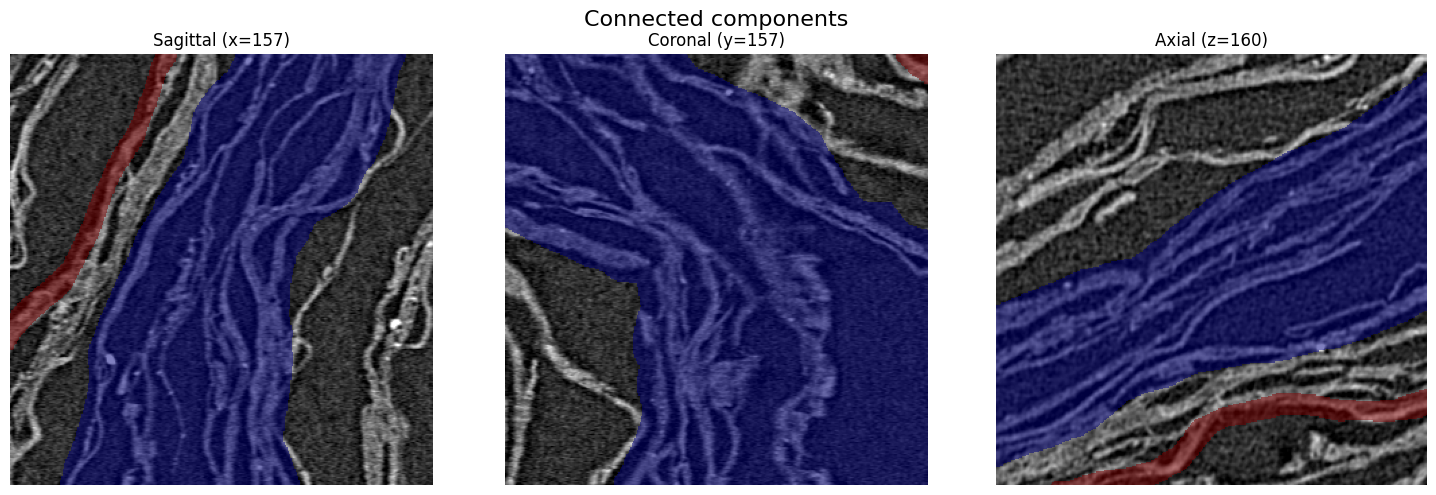

In [ ]:
# Load to numpy
file_example = join(DATASET_PATH, "train_images_nii/2290837.nii.gz")
label_example = join(DATASET_PATH, "train_labels_nii/2290837.nii.gz")
volume_data, affine = load_nii(file_example)
label_data, affine = load_nii(label_example)
# Crop the edges 0
volume_data_crop, label_data_crop = crop_edges_without_content(volume_data, label_data)
# Get individual componets masks
segmented_mask, num_regions = get_connected_components(label_data_crop)
plot_3d(volume_data_crop, label_data=segmented_mask, title="Connected components", alpha=0.5)

#segmented_mask_no_crop, num_regions = get_connected_components(label_data)
#plot_3d(volume_data, label_data=segmented_mask_no_crop, title="Connected components (no crop)", alpha=0.5)

In [30]:
segmented_mask.shape

(314, 314, 320)

## Now that we have the individual componets, let's extract them from the remaining volume




In [ ]:

# Load to numpy
file_example = join(DATASET_PATH, "train_images_nii/2290837.nii.gz")
label_example = join(DATASET_PATH, "train_labels_nii/2290837.nii.gz")
volume_data, affine = load_nii(file_example)
label_data, affine = load_nii(label_example)
# Crop the edges 0
volume_data_crop, label_data_crop = crop_edges_without_content(volume_data, label_data)
# Get individual componets masks
segmented_mask, num_regions = get_connected_components(label_data_crop)
plot_3d(volume_data_crop, label_data=segmented_mask, title="Connected components", alpha=0.5)
# For each region, crop the remaining content, and set undefined as 0 in the volume.
for n_regions in range(num_regions):
    boolean_mask = segmented_mask == (n_regions + 1)
    volume_data_crop_final, label_data_crop_final = crop_edges_without_content(volume_data_crop, boolean_mask)
    volume_data_crop_final[label_data_crop_final==2] == 0
    

In [28]:
output_path = "/projects/nian/synthrad2025/Vesuvius/trash/segmented_mask.nii.gz"
save_nii_with_metadata(
    data_to_save=segmented_mask,
    original_nii_file_path=label_example, 
    output_filepath=output_path
    )

Successfully saved mask to: /projects/nian/synthrad2025/Vesuvius/trash/segmented_mask.nii.gz


'/projects/nian/synthrad2025/Vesuvius/trash/segmented_mask.nii.gz'